In [1]:
import numpy as np

import pint
ureg = pint.UnitRegistry(system='mks')
ureg.setup_matplotlib(True)

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from collections.abc import Iterable


In [2]:
def si(v):
    try:
        return v.to_base_units().magnitude
    except:
        try:
            return [si(vv) for vv in v]
        except: 
            raise RuntimeError('Conversion to SI has failed')
            
def mach_correction(Ma=0.0):
    """Performs the Prandtl-Glauert compressibility correction."""

    #my own correction:
    beta = max(np.sqrt(abs(1-Ma**2)), np.sqrt(1-0.8**2))
    
    return 1/beta
    
    #Follows the formulation of eqn. 55-57 of Box:
    #if Ma < 0.8:
    #    return 1/np.sqrt(1-Ma**2)
    #elif Ma > 1.1:
    #    return 1/np.sqrt(Ma**2-1)
    #else:
    #    return 1/np.sqrt(1-0.8**2)

In [53]:
class Rocket():
    
    def __init__(self, name='Rocket'):

        self.name = name
            
        
        self.components = []
        
        self.nose_cone = None
        self.body_tube = None
        self.fins = None
        self.boat_tail = None
        
        
        self.A_ref = 0*ureg.inch**2
        
        
        return
    
    def __repr__(self):
        return f'{self.name}'
     
    def add(self, component):
        
        if isinstance(component, Iterable):
            component_unique = [comp for comp in component if comp not in self.components]
            self.components.extend(component_unique)
        elif component not in self.components:
            self.components.append(component)
            
        return None
    
    def set_boat_tail(self, component):
        
        """Set the boat tail component"""
        
        if component in self.components:
            # find the boat tail in the list of components
            boat_tail = [comp for comp in self.components if component == comp][0]
        else:
            boat_tail = component
            self.add(component)
            
        self.boat_tail = boat_tail
        
        return None
    
    def set_fins(self, component):
        
        """Set the fin set of the rocket"""
        
        if component in self.components:
            # find the fins in the list of components
            fins = [comp for comp in self.components if component == comp][0]
        else:
            fins = component
            self.add(fins)

        self.fins = fins
        return None
    
    def set_nose_cone(self, component):
        
        """Set the nose cone of the rocket"""
        
        if component in self.components:
        
            # find the nc in the list of components
            nc = [comp for comp in self.components if component == comp][0]
        else:
            nc = component
            self.add(nc)

        self.nose_cone = nc
        
        # define the A_ref here.
        self.A_ref = nc.A_ref
        
        return None
    
    def set_body_tube(self, component):
        
        """Set the body tube of the rocket"""
        
        if component in self.components:
        
            # find the body tube in the list of components
            bt = [comp for comp in self.components if component == comp][0]
        else:
            bt = component
            self.add(bt)

        self.body_tube = bt
        
        return None
        
        
    def plot(self, ax=None, unit=ureg.m, rotation=0*ureg.degree, plot_component_cp=True,plot_component_cg=True, alpha=0*ureg.degree, Re=1e6, Mach=0.3):
        
        if not ax:
            ax = plt.gca()
            
        for comp in self.components:
            comp.plot(ax, rotation=rotation, unit=unit)
     
        
        if plot_component_cp:
            self.plot_cp(ax, unit=unit, alpha=alpha, Re=Re, Mach=Mach)
            
        if plot_component_cg:
            self.plot_cg(ax, unit=unit)
            
        plt.axis('equal')
        plt.grid(True)
        plt.xlabel(f'x [{str(unit)}]')
        plt.ylabel(f'y or z [{str(unit)}]')
        
        return ax
    
    def plot_cp(self, ax=None, unit=ureg.m, alpha=0*ureg.degree, Re=1e6, Mach=0.3):
        
        if not ax:
            ax = plt.gca()
        
        # plot for components
        for comp in self.components:
            ax.plot((comp.x_ref+comp.xcp(alpha, Re, Mach)).m_as(unit), 0, 'kx')
            
        # plot for rocket
        ax.plot(self.xcp().m_as(unit), 0, 'rx')
        
        return ax
    
    def plot_cg(self, ax=None, unit=ureg.m):
        
        if not ax:
            ax = plt.gca()
        
        # plot for components
        for comp in self.components:
            ax.plot((comp.x_ref+comp.xcg()).m_as(unit), 0, 'ko')
        
        # plot for rocket
        ax.plot(self.xcg().m_as(unit), 0, 'ro')
        
        return ax
    
    
    def length(self):
        return sum(comp.length for comp in self.components)
        
    def CNa(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        CNa = sum(comp.CNa(alpha, Re, Mach) for comp in self.components)
        
        return CNa
    
    def CN(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        return self.CNa(alpha, Re, Mach) * alpha
        
    def xcp(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        xcp = sum(comp.CNa(alpha, Re, Mach) * (comp.A_ref/self.A_ref) * (comp.x_ref + comp.xcp(alpha, Re, Mach)) for comp in self.components) / self.CNa(alpha, Re, Mach)
        
        return xcp
    
    def mass(self):
        
        m = sum(comp.mass for comp in self.components)
        
        return m
    def xcg(self):
        
        xcg = sum(comp.mass * (comp.x_ref + comp.xcg()) for comp in self.components) / self.mass()
        
        return xcg
    
    def CD(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        """Calculate the drag force at some angle of attack, including compressibility"""
        
        CD0 = self.CD0(Re)
        CD_body_alpha = self.CD_body_alpha(alpha)
        CD_fin_alpha = self.CD_fin_alpha(alpha)
        
        CD = CD0 + CD_body_alpha + CD_fin_alpha
        
        # perform a mach number correction
        CD = CD*mach_correction(Mach)
        
        return CD

    def CA(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        """Compute the axial drag force from the normal force and the axial force"""
        
        # get 0 mach CD:
        CD = self.CD(alpha, Re, Mach)
        CN = self.CN(alpha, Re, Mach)
        
        # eqn. 54 of Box 2009
        CA = (CD*np.cos(alpha) - 0.5*CN*np.sin(2*alpha))/(1-np.sin(alpha)**2)
        
        return CA
        
        
    def CD_body_alpha(self, alpha=0*ureg.rad):
        
        def delta(alpha):
            # in radians (by fitting to Fig. 4 of Box 2009)
            # collected raw data: (alpha (deg), delta) = {{4, 0.780021417}, {6, 0.857352918}, {8, 0.92048524}, {10, 0.940041875}, {12, 0.960026851}, {16, 0.975050746}, {18, 0.980015024}}
            return 1 - 0.518535*np.exp(-0.00378764*alpha)
        
        def eta(alpha):
            # in radians
            return 0.259348*alpha**0.153029
        
        l_TR = self.length()
        l_n = self.nose_cone.length
        alpha = alpha.m_as(ureg.rad) # ensure its in radians
        
        # maximum body diameter of rocket
        d_b = max([comp.diameter for comp in self.components if type(comp) is BodyTube])
        
        
        CD_body_alpha = 2*delta(alpha)*alpha**2 + (3.6 * eta(alpha) * ((1.36 * l_TR - 0.55* l_n))/(np.pi * d_b)) * alpha**3
        
        return CD_body_alpha
    
    def CD_fin_alpha(self, alpha):
        
        alpha = alpha.to(ureg.rad).magnitude #ensure its in radians
        
        A_fp = self.fins.planform_area
        A_fe = self.fins.exposed_area
        d_f = self.fins.tube_dia
        l_TS = d_f + 2*self.fins.span # total fin span
        n = self.fins.n
        
        Rs = l_TS/d_f
        
        k_fb = 0.8065*Rs**2 + 1.1553*Rs
        k_bf = 0.1935*Rs**2 + 0.8174*Rs + 1
        
        
        #TODO: check this equation (eqn. 50 in Box 2009) - the typography seems odd
        CD_falpha = alpha**2 * ((1.2 * n * A_fp) / (np.pi * d_f**2) + 3.12*(k_fb + k_bf - 1)*(n * A_fe)/(np.pi * d_f**2))
        
        return CD_falpha
        
    def CD0(self, Re=1e6):
        """Calcualte the zero angle-of-attack incompressible drag of the rocket. 
        Generally uses DATCOM method (as specified by Box [1])
        Reynolds number refers to the reynolds number by the length of the rocket. """
        
        CD0_fb = self.CD0_fb(Re)
        CD0_b  = self.CD0_b(Re)
        CD0_f  = self.CD0_f(Re)
        
        return CD0_fb + CD0_b + CD0_f
    
    def CD0_fb(self, Re=1e6):
        """Calcualte the zero-angle of attack drag due to forebody of the rocket"""
        
        #total length of the rocket
        l_TR = self.length()
        
        if self.boat_tail is not None:
            # length of the boat tail
            l_c = self.boat_tail.length
            # diameter at boat tail
            d_d = self.boat_tail.aft_dia
        else:
            l_c = 0*ureg.m;
            d_d = 0*ureg.m;
        
        # maximum body diameter of rocket
        d_b = max([comp.diameter for comp in self.components if type(comp) is BodyTube])
        
        # length of body tube
        l_b = sum([comp.length for comp in self.components if type(comp) is BodyTube])
        
        # length of nose cone
        l_n = self.nose_cone.length
        
        # coefficient of friction of fore body
        Cf_fb = self.Cf(Re=Re)
        
        CD0_fb = (1+60/(l_TR/d_b)**3 + 0.0025*(l_b/d_b))*(2.7*(l_n/d_b) + 4*(l_b/d_b) + 2*(1 - d_d/d_b)*(l_c/d_b))*Cf_fb
        
        return CD0_fb
    
    def CD0_b(self, Re=1e6):
        """Calcualte the zero-angle of attack drag due to base drag"""
        
        if self.boat_tail is None:
            raise NotImplementedError
        else:
            # find max dia
            d_b = max([comp.diameter for comp in self.components if type(comp) is BodyTube])
            # find boat dia aft dia
            d_d = self.boat_tail.aft_dia
            
        CD0_b = 0.029*(d_d/d_b)**3/(self.CD0_fb(Re))**0.5
            
        
        return CD0_b
    
    def CD0_f(self, Re=1e6):
        """Calcualte the zero-angle of attack drag due to the fins, including the effect of the interference"""
        
        if self.fins is None:
            raise RuntimeError("Please define the fins using rocket.set_fins(fins) first.")
        
        l_TR = self.length()
        
        l_m_fins = self.fins.mid_chord_span
        t_f = self.fins.thickness
        A_fp = self.fins.planform_area
        A_fe = self.fins.exposed_area
        d_f = self.fins.tube_dia
        n = self.fins.n
        
        Re_fins = Re*(l_m_fins/l_TR)
        Cf_f = self.Cf(Re_fins)
        
        
        CD0_f = 2 * Cf_f * (1 + 2*t_f/l_m_fins) * (4 * n * (2*A_fp - A_fe)) / (np.pi * d_f**2)
        
        return CD0_f
        
    
    def Cf(self, Re=1e6):
        """Return the viscous friction coefficient at a Reynolds number"""
        
        Re_c = 5e5; #critical reynolds number for transition
        
        if Re < Re_c:
            Cf = 1.328/np.sqrt(Re)
            return Cf
        
        else:
            B = Re_c*(0.074*Re**(-0.2) - 1.328*Re**(-0.5))
            
            Cf = 0.074*Re**(-0.2) - B/Re
            
            
            return Cf

In [54]:
class Component():
    
    def __init__(self, name='Component', mass=None, inertia = None):
        
        self.name = name
        
        # mass properties
        if callable(mass):
            self.mass = mass()
        elif mass is None:
            self.mass = self.estimate_mass()
        else:
            self.mass = mass
            
        self.mass = self.mass.to(ureg.kg)
            
        # moment of inertias
        # assumed to be 0 initially, but should be replaced
        if callable(inertia):
            self.I_xx, self.I_yy, self.I_zz = inertia()
        elif mass is None:
            self.I_xx, self.I_yy, self.I_zz = self.estimate_inertia()
        else:
            self.I_xx, self.I_yy, self.I_zz = inertia

        
        # this is the leading reference coordinate of the component, x is along rocket axis, increasing from nose backwards. 
        self.x_ref = 0*ureg.meter
        self.y_ref = 0*ureg.meter
        self.z_ref = 0*ureg.meter
        
        # reference area to be used for drag and lift force calculations. 
        self.A_ref = None
        
        # this is the length of the component that contributes to the rockets length. 
        # internal components have 0 length, but the diagram draws the correct lengths and diameters.
        self.l_ref = 0*ureg.meter 
        
    
    def estimate_mass(self):
        """Generic method to estimate the mass of the component - assume mass is 0.
        This method should be overridden for each component specified"""
        return 0.0*ureg.kg
    
    def estimate_inertia(self):
        """Generic method to estimate the mass of the component - assume inertia is 0.
        This method should be overridden for each component specified"""
        
        return (0.0*ureg.kg/(ureg.m**2), 0.0*ureg.kg/(ureg.m**2), 0.0*ureg.kg/(ureg.m**2))
    
    def set_position(self, before=None, after=None, middle_of=None, offset=0*ureg.m):
        
        if before is not None:
            
            self.x_ref = before.x_ref - self.length + offset
            
            return
        
        elif after is not None:
            
            self.x_ref = after.x_ref + after.length  + offset
            
            return 
            
        elif middle_of is not None:
            
            self.x_ref = middle_of.x_ref + middle_of.length/2 - self.length/2  + offset
            
            return
        
        else:
            raise ValueError('The location must be specified')
            
    
    def __repr__(self):
        return f'{self.name} (type: {self.__class__.__name__})'
    
    
    def plot(self, ax=None, rotation=0*ureg.degree, unit=ureg.m):
        
        if ax is None:
            ax = plt.gca()
        
        for coords in self.plot_coords(rotation=rotation):
            
            if coords is not None:
                
                # convert to specified units
                coords2 = np.array([[c[i].m_as(unit) for i in [0,1]] for c in coords])
                
                poly = Polygon(coords2, facecolor='none',edgecolor='k')

                ax.add_patch(poly)
        
        plt.axis('equal')
        plt.grid(True)
        plt.xlabel(f'x [{str(unit)}]')
        plt.ylabel(f'y or z [{str(unit)}]')
        return ax
    
    def plot_coords(self):
        return None
    
    def xcp(self, *args):
        
        return 0*ureg.m
    
    def xcg(self, *args):
        
        return 0*ureg.m
    
    ## Todo build up this functionality
    

In [55]:
class InternalComponent(Component):
    
    def __init__(self, name='Internal Component', mass=None, inertia=None):
        
        super().__init__(name=name, mass=mass, inertia=inertia)
        
    def CN(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        return 0.0
        
class ExternalComponent(Component):
    
    def __init__(self, name='External Component', mass=None, inertia=None, A_ref = np.pi*(3*ureg.inch)**2):
        
        super().__init__(name=name, mass=mass, inertia=inertia)
        
        self.A_ref = A_ref
        
    def CNa(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        return 0.0/ureg.rad
        
    def CN(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        return self.CNa(alpha, Re, Mach)*alpha
        

In [56]:
class Cylinder(InternalComponent):
    
    def __init__(self, name='Internal Cylinder', mass=None, inertia=None, diameter=6*ureg.inch, length = 6*ureg.inch, density=None):
        super().__init__(name = name, mass = mass, inertia = inertia)
        
        self.diameter = diameter
        self.length = length
        self.density = density
        
    
    def estimate_mass(self):
        if not self.density.check(ureg.kg/(ureg.m**3)): 
            raise ValueError('Density must have the right units')

        V = np.pi*(self.diameter/2)**2 * self.length
        
        m = self.density * V 
        
        return m
    
    def estimate_inertia(self):
        
        m = self.mass
        r = self.diameter/2
        h = self.length
        
        I_xx = 0.5 * m * r**2
        I_yy = (1/12) * m * (3*r**2 + h**2)
        
        #note, I_yy = I_zz
        return I_xx, I_yy, I_yy
        

In [57]:
class Material():
    
    def __init__(self, name):
        
        self.name = name
        
        self.density = 0*ureg.km/(ureg.m**3)
        
        
    def __repr__(self):
        
        return f'{self.name}: (Material))'
        
class Aluminium(Material):
    
    def __init__(self, name='Al-6061-T6'):
        
        super().__init__(name=name)
        
        self.density = 2.7*ureg.g/(ureg.cm**3)
        self.tensile_mod = 69*ureg.GPa
        self.tensile_strength = 270*ureg.MPa
        self.max_temp = 420*ureg.degK
        
        
class PLA(Material):
    
    def __init__(self, name='PLA'):
        
        super().__init__(name=name)
        
        self.density = 1.05*ureg.g/(ureg.cm**3)

        
class Phenolic(Material):
    
    def __init__(self, name='PLA'):
        
        super().__init__(name=name)
        
        self.density = 1.35*ureg.g/(ureg.cm**3)
        # TODO: (high) Check material properties
        

In [58]:
class NoseCone(ExternalComponent):
    
    def __init__(self, name='Nose Cone', mass=None, inertia=None, shape='Conical', diameter=None, length=None, fineness=None, wall_thickness=2*ureg.mm, material=None):
        # note, the plotting currently assumes its a conical nose. 
        
        # use the base diameter for the reference area
        A_ref = np.pi*diameter**2 / 4
            
        self.shape = shape
        
        self.x_ref = 0*ureg.m

        if diameter and length:
            self.diameter = diameter
            self.length = length
        elif diameter and fineness:
            self.diameter = diameter
            self.length = fineness*self.diameter     
        elif length and diameter:
            self.length = length
            self.diameter = length/fineness
            
        self.wall_thickness = wall_thickness
        self.material = material
        
        super().__init__(name=name, mass=mass, inertia=inertia, A_ref=A_ref)
        
    def estimate_mass(self):
        """Method to estimate the mass of the nose cone"""
        
        L = self.length
        R = self.diameter/2
        t = self.wall_thickness
        rho = self.material.density
        
        return rho*t*L*np.pi*R
    def estimate_inertia(self):
        
        L = self.length
        R = self.diameter/2
        t = self.wall_thickness
        m = self.mass
        
        I_xx = m*(R**2/2)
        I_yy = m*(L**2/18)
        
        
        return I_xx, I_yy, I_yy
        
        
        
        
    def xcg(self):
        
        return (2/3)*self.length    
        
        
    def CNa(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        # eq 25 of [1]
        
        CNa_incomp = 2/(1*ureg.rad) # per radian
        
        CNa = CNa_incomp*mach_correction(Mach)
        
        return CNa
    
    def xcp(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        # at the moment we assume the Xcp doesnt change with Mach
        
        if self.shape == 'Conical':
            return (2/3)*self.length
        elif self.shape == 'Ogive':
            return (5/8)*self.length
        elif self.shape == 'Parabolic':
            return (3/5)*self.length
        else:
            raise RuntimeError('Please set the nose cone shape to a supported string')
    
    def plot_coords(self,rotation=0*ureg.degree):
        
        l = self.length
        r = self.diameter/2
        
        coords = [[0*ureg.m, 0*ureg.m], [l, r], [l, -r]]
        
        coords_shift = [[self.x_ref + c[0], c[1]] for c in coords]
        
        yield coords_shift
    
class Transition(ExternalComponent):
    
    def __init__(self, name = 'Transition', mass=None, inertia=None, fore_dia=None, aft_dia=None, length=None, wall_thickness=2*ureg.mm, material=None):
        
        # use the base diameter for the reference area
        self.A_ref = np.pi*fore_dia**2 / 4
        
        self.fore_dia = fore_dia
        self.aft_dia = aft_dia
        self.d_ref = 2*(self.A_ref/np.pi)**0.5
        self.length = length
        self.wall_thickness = wall_thickness
        self.material = material
        
        super().__init__(name=name, mass=mass, inertia=inertia, A_ref=self.A_ref)
        
    def estimate_mass(self):
        
        r0 = self.fore_dia/2
        r1 = self.aft_dia/2
        L = self.length
        t = self.wall_thickness
        rho = self.material.density
        
        
        m = rho*L*(np.pi*(r0+r1))*t
        
        return m
    
    def estimate_inertia(self):
        
        L = self.length
        r0 = self.fore_dia/2
        r1 = self.aft_dia/2
        m = self.mass
        
        I_xx = m*(0.5*(r0**2 + r1**2))
        
        I_yy = m*(L**2*(r0**2 + 4*r0*r1 + r1**2))/(18*(r0 + r1)**2)

        return I_xx, I_yy, I_yy
    
    def xcg(self):
        
        r0 = self.fore_dia/2
        r1 = self.aft_dia/2
        L = self.length
        
        return (L/3)*(r0+2*r1)/(r0+r1)
    
    def CNa(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        CNa_incomp = 2*((self.aft_dia/self.d_ref)**2 - (self.fore_dia/self.d_ref)**2) / (1*ureg.rad)
        
        CNa = CNa_incomp*mach_correction(Mach)
        
        return CNa
        
    def xcp(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        d_fore = self.fore_dia
        d_aft = self.aft_dia
        
        #eqn 40 of ref[1]
        return (self.length/3) * ((d_fore + 2 * d_aft)/(d_fore + d_aft))
    
    def plot_coords(self,rotation=0*ureg.degree):
        
        l = self.length
        fore_r = self.fore_dia/2
        aft_r = self.aft_dia/2
        
        coords = [[0*ureg.m, fore_r], [l, aft_r], [l, -aft_r],[0*ureg.m, -fore_r]]
        
        coords_shifted = [[self.x_ref + c[0], c[1]] for c in coords]
        
        yield coords_shifted
    

class BodyTube(ExternalComponent):
    
    
    def __init__(self, name = 'Body Tube', mass=None, inertia=None, diameter=None, length=None, wall_thickness=2*ureg.mm, material=None):
        
        self.A_ref = np.pi*diameter**2 / 4
        self.d_ref = diameter
        self.diameter = diameter
        self.length = length
        self.wall_thickness = wall_thickness
        self.material = material
        
        super().__init__(name=name, mass=mass, inertia=inertia, A_ref=self.A_ref)
    
    def estimate_mass(self):
        
        r0 = self.diameter/2
        L = self.length
        t = self.wall_thickness
        rho = self.material.density
        
        m = 2*rho*L*np.pi*r0*t
        
        return m
    
    def estimate_inertia(self):
        
        m = self.mass
        r0 = self.diameter/2
        L = self.length
        
        I_xx = m*r0**2
        
        I_yy = m*(L**2/12)
  
        # note Iyy=Izz
        return I_xx, I_yy, I_yy
    
    def xcg(self):
        
        return self.length/2
        
    def plot_coords(self,rotation=0*ureg.degree):
        
        l = self.length
        r = self.diameter/2
        
        coords = [[0*ureg.m, r], [l, r], [l, -r],[0*ureg.m, -r]]
    
        coords_shifted = [[self.x_ref + c[0], c[1]] for c in coords]
            
        yield coords_shifted
    
        
    def CNa(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3, K=1.1):
        
        planform_area = self.diameter * self.length
        
        CNa_incomp = (K*planform_area/self.A_ref) * alpha /((1*ureg.rad)**2)
    
        CNa = CNa_incomp*mach_correction(Mach)
        
        return CNa
    
    def xcp(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        return self.length/2
    
    
        
    
class FinSet(ExternalComponent):
    
    def __init__(self, name = 'Fins', mass = None, inertia = None, n=None, span=None, root_chord=None, tip_chord=None, mid_sweep=None, tube_dia = None, thickness=None, material=None):
        
        # midsweep is the sweep angle at the mid-chord locations
        
        self.A_ref = np.pi*tube_dia**2 / 4
        
        self.d_ref = 2*(self.A_ref/np.pi)**0.5
        
        self.n = n
        self.span = span
        self.root_chord = root_chord
        self.tip_chord = tip_chord
        self.mid_sweep = mid_sweep
        self.mid_chord_span = self.span/np.cos(self.mid_sweep)
        
        self.tube_dia = tube_dia
        self.length = 0*ureg.m # used in calculating the overall length of the rocket
        self.thickness = thickness
        
        self.exposed_area = 0.5 * (self.root_chord + self.tip_chord) * self.span # per fin
        self.planform_area = self.exposed_area + 0.5 * self.tube_dia * self.root_chord # per fin        
        
        self.material = material
        
        super().__init__(name=name, mass=mass, inertia=inertia, A_ref=self.A_ref)
    
    def leading_sweep(self):
        """Return the leading edge sweep of the fins"""
        
        lr = self.root_chord
        lt = self.tip_chord
        ls = self.span
        sweep = self.mid_sweep
        
        tip_le = lr/2 + ls*np.tan(sweep) - lt/2 #tip leading edge
        
        leading_sweep = np.arctan(tip_le/ls)
        
        return leading_sweep
            
    def CNa(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        if self.n <= 4:
            body_influence = 1 +     (self.tube_dia/2)/(self.span + self.tube_dia/2)
        elif self.n > 4:
            body_influence = 1 + 0.5*(self.tube_dia/2)/(self.span + self.tube_dia/2)
        
        CNa_incomp = (body_influence * (4*self.n*(self.span/self.d_ref)**2) / (1 + (1 + (self.mid_chord_span/(self.root_chord + self.tip_chord))**2)**0.5) ) / (1*ureg.rad)
        
        CNa = CNa_incomp * mach_correction(Mach)
        
        return CNa
    
    def xcp(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        lm = self.mid_chord_span
        lr = self.root_chord
        lt = self.tip_chord
        
        a = lm * (lr + lt) / (3 * (lr + lt))
        b = (1/6) * (lr + lt - (lr*lt)/(lr + lt))
        
        return a + b
    
    def plot_coords(self, rotation=0*ureg.rad):  
        
        r = self.tube_dia/2
        lr = self.root_chord
        lt = self.tip_chord
        lm = self.mid_chord_span
        ls = self.span
        sweep = self.mid_sweep
        
        tip_le = lr/2 + ls*np.tan(sweep) - lt/2 #tip leading edge
        
        x_ref = self.x_ref
        
        coords_single = [[x_ref, r, 0*ureg.m], [x_ref + tip_le , r + ls, 0*ureg.m], [x_ref + tip_le + lt, r + ls, 0*ureg.m], [x_ref + lr, r, 0*ureg.m]]
        
        coords_single_si = np.array([[si(cc) for cc in c] for c in coords_single])
        
        th_set = np.linspace(0, 2*np.pi, self.n, endpoint=False)
        
        poly_set = []

        for th in th_set:
            
            th2 = th + rotation.m_as(ureg.rad)
            
            R2 = np.array([[1, 0, 0], [0, np.cos(th2), -np.sin(th2)]])
            
            coords_rotated = (R2 @ coords_single_si.T).T
            
            coords_units = [[c[0]*ureg.m, c[1]*ureg.m] for c in coords_rotated]
            
            yield coords_units
        
        
    
    #references:
    #[1]: Simon Box, 2009, Estimating the dynamic and aerodynamic paramters of passively controlled high power rockets for flight simulaton
        

# Example Usage

In [110]:
r = Rocket('Sample Rocket')
r

Sample Rocket

In [111]:
# create a nose cone
nc = NoseCone(mass=None, inertia=None, diameter=6*ureg.inch, length=18*ureg.inch, wall_thickness=6*ureg.mm, material=PLA())
# assign it to the rocket
r.set_nose_cone(nc)
nc

Nose Cone (type: NoseCone)

In [112]:
nc.mass.to(ureg.kg)

0.6895275375558748 <Unit('kilogram')>

In [113]:
nc.I_zz.to_base_units()

0.008007400550331866 <Unit('kilogram * meter ** 2')>

In [114]:
nc.material

PLA: (Material))

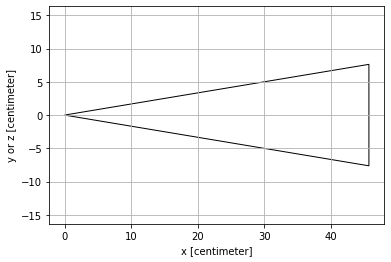

In [115]:
# plot the nose cone
fig = plt.figure()
ax = plt.gca()
#the pint functionality to apply a unit does not currently work
#ax.yaxis.set_units(ureg.meters)
#ax.xaxis.set_units(ureg.inches)
nc.plot(ax, unit=ureg.cm);

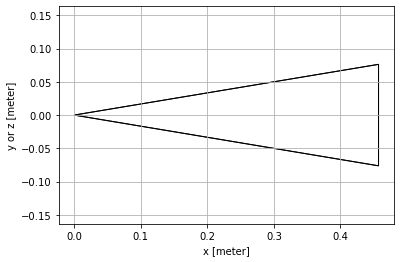

In [116]:
nc.plot(rotation=0*ureg.degree)
nc.plot(rotation=60*ureg.degree)


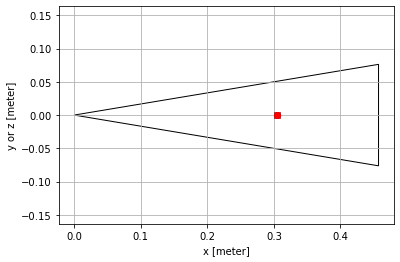

In [117]:
r.plot()

In [118]:
# determine the normal force coefficient at some alpha
nc.CN(alpha=0.2*ureg.rad)

0.4193139346887673 <Unit('dimensionless')>

In [119]:
nc.xcp()

12.0 <Unit('inch')>

In [120]:
Phenolic()

PLA: (Material))

In [121]:
# create a body tube
bt = BodyTube(name = 'Body Tube', mass =None, inertia=None, diameter=6*ureg.inch, length=48*ureg.inch, wall_thickness=2*ureg.mm, material=Phenolic())

# define its location
bt.set_position(after=nc)

# assign to the rocket
r.set_body_tube(bt)
print(bt)

Body Tube (type: BodyTube)


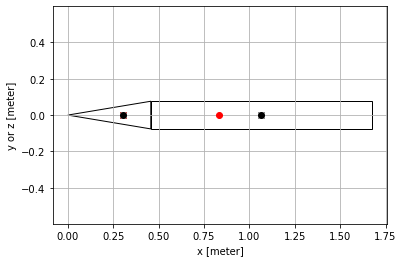

In [122]:
# plot the rocket so far
r.plot(plot_component_cg=True, unit=ureg.m)

In [123]:
r.xcp().to(ureg.inch)

11.999999999999998 <Unit('inch')>

In [124]:
# create a boat tail
boat_tail = Transition(name='Boat Tail',mass=None, inertia=None, fore_dia=6*ureg.inch, aft_dia=4*ureg.inch, length=4*ureg.inch, material=Phenolic())
boat_tail.set_position(after=bt)
r.set_boat_tail(boat_tail)
boat_tail

Boat Tail (type: Transition)

In [125]:
# get the normal force coefficient for the boat tail.
boat_tail.CNa()

-1.1647609296910202 <Unit('1 / radian')>

In [126]:
r.xcp().to(ureg.inch)

-57.833333333333336 <Unit('inch')>

In [127]:
# create the fins
fins = FinSet(name='Fins', mass=None, inertia=None, n=3, span=6*ureg.inch, root_chord=12*ureg.inch, tip_chord=6*ureg.inch, mid_sweep=10*ureg.degree, tube_dia=6*ureg.inch,  thickness=6*ureg.mm, material=Aluminium())

fins.set_position(after=bt, offset=-fins.root_chord)
# assign fins to the rocket
r.set_fins(fins)
fins

Fins (type: FinSet)

In [128]:
# you can get a slightly ugly print out of all the parameters, using Python's built in (__dict__)
for d in fins.__dict__:
    print(f'{d:20s}: \t {fins.__dict__[d]}' )

A_ref               : 	 28.274333882308138 inch ** 2
d_ref               : 	 6.0 inch
n                   : 	 3
span                : 	 6 inch
root_chord          : 	 12 inch
tip_chord           : 	 6 inch
mid_sweep           : 	 10 degree
mid_chord_span      : 	 6.09255967131447 inch
tube_dia            : 	 6 inch
length              : 	 0 meter
thickness           : 	 6 millimeter
exposed_area        : 	 54.0 inch ** 2
planform_area       : 	 90.0 inch ** 2
material            : 	 Al-6061-T6: (Material))
name                : 	 Fins
mass                : 	 0.0 kilogram
I_xx                : 	 0.0 kilogram / meter ** 2
I_yy                : 	 0.0 kilogram / meter ** 2
I_zz                : 	 0.0 kilogram / meter ** 2
x_ref               : 	 1.3716 meter
y_ref               : 	 0 meter
z_ref               : 	 0 meter
l_ref               : 	 0 meter


In [129]:
fins.leading_sweep().to(ureg.deg)

34.0715499842578 <Unit('degree')>

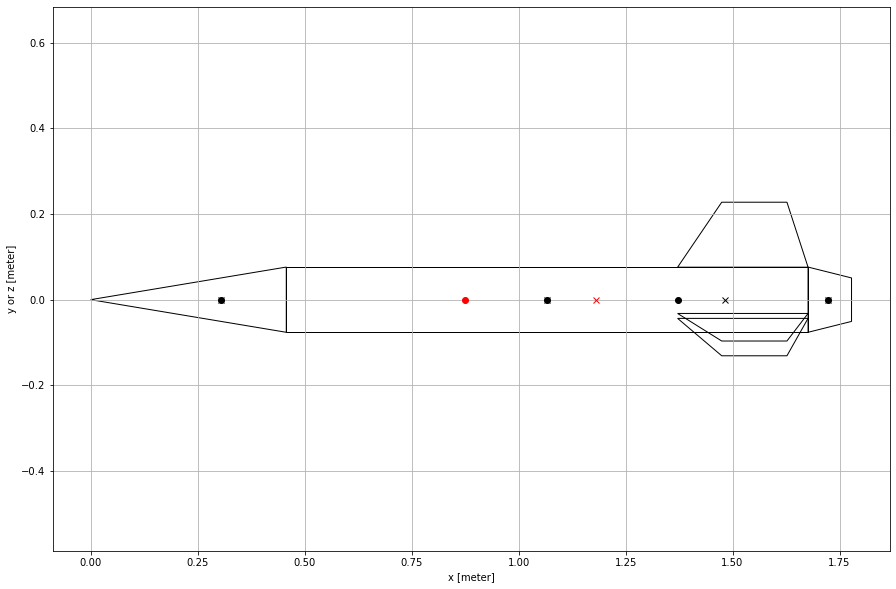

In [154]:
# plot the entire rocket
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
r.plot(ax, rotation=5*ureg.degree, plot_component_cp=True,plot_component_cg=True)

In [131]:
# its also a good idea to do a check of the components list:
r.components

[Nose Cone (type: NoseCone),
 Body Tube (type: BodyTube),
 Boat Tail (type: Transition),
 Fins (type: FinSet)]

In [132]:
# and the total length of the rocket
print(r.length())
print(r.length().to_base_units())

70.0 inch
1.778 meter


In [133]:
# query some parameters of the rocket
r.xcp().to(ureg.inch)

46.45383871765168 <Unit('inch')>

In [134]:
r.CNa()

9.090739119947763 <Unit('1 / radian')>

In [135]:
r.components

[Nose Cone (type: NoseCone),
 Body Tube (type: BodyTube),
 Boat Tail (type: Transition),
 Fins (type: FinSet)]

In [136]:
r.components[0].xcp()

12.0 <Unit('inch')>

In [137]:
si(sum(comp.length for comp in r.components))

1.778

In [138]:
r.components

[Nose Cone (type: NoseCone),
 Body Tube (type: BodyTube),
 Boat Tail (type: Transition),
 Fins (type: FinSet)]

In [139]:
alphas = np.linspace(0, 20)*ureg.degree
CNs = np.array([bt.CN(alpha) for alpha in alphas])

/Users/Devansh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Array protocol attribute __array_interface__ accessed, with unit of the Quantity being stripped. This attribute will become unavailable in the next minor version of Pint. To make this potentially incorrect attribute unavailable now, set the PINT_ARRAY_PROTOCOL_FALLBACK environment variable to 0 before importing Pint.
  


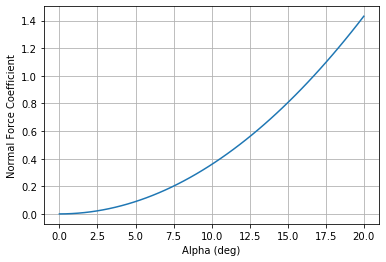

In [140]:
plt.plot(alphas.to(ureg.degree), CNs)
plt.grid();
plt.xlabel('Alpha (deg)');
plt.ylabel('Normal Force Coefficient');

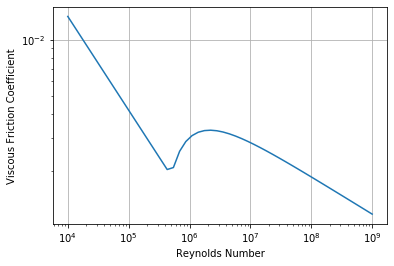

In [141]:
re_vals = np.logspace(4, 9)
plt.loglog(re_vals, [r.Cf(re) for re in re_vals])
plt.xlabel('Reynolds Number')
plt.ylabel('Viscous Friction Coefficient')
plt.grid()

In [142]:
# try to get the zero-angle of attack drag coefficient
r.CD0()

0.2822518251439863 <Unit('dimensionless')>

Text(0, 0.5, 'CD0 of Rocket')

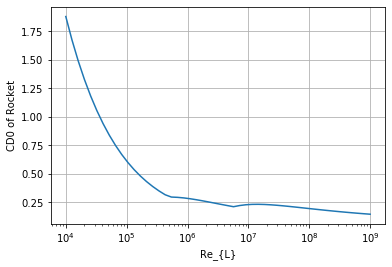

In [143]:
# plot this as a function of the drag coefficient
plt.semilogx(re_vals, [r.CD0(re) for re in re_vals])
plt.grid()
plt.xlabel("Re_{L}")
plt.ylabel("CD0 of Rocket")

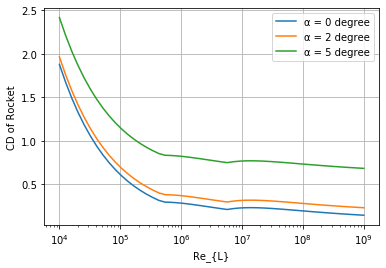

In [144]:
plt.semilogx(re_vals, [r.CD(alpha=0*ureg.degree, Re=re, Mach=0.0) for re in re_vals], label='α = 0 degree')
plt.semilogx(re_vals, [r.CD(alpha=2*ureg.degree, Re=re, Mach=0.0) for re in re_vals], label='α = 2 degree')
plt.semilogx(re_vals, [r.CD(alpha=5*ureg.degree, Re=re, Mach=0.0) for re in re_vals], label='α = 5 degree')
plt.grid()
plt.xlabel("Re_{L}")
plt.ylabel("CD of Rocket")
plt.legend()

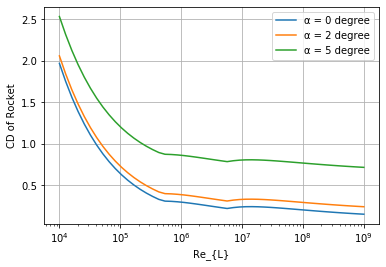

In [145]:
plt.semilogx(re_vals, [r.CD(alpha=0*ureg.degree, Re=re, Mach=0.3) for re in re_vals], label='α = 0 degree')
plt.semilogx(re_vals, [r.CD(alpha=2*ureg.degree, Re=re, Mach=0.3) for re in re_vals], label='α = 2 degree')
plt.semilogx(re_vals, [r.CD(alpha=5*ureg.degree, Re=re, Mach=0.3) for re in re_vals], label='α = 5 degree')
plt.grid()
plt.xlabel("Re_{L}")
plt.ylabel("CD of Rocket")
plt.legend()

In [146]:
np.log10((1.225*300*2)/1.8e-5)

7.611014833980889

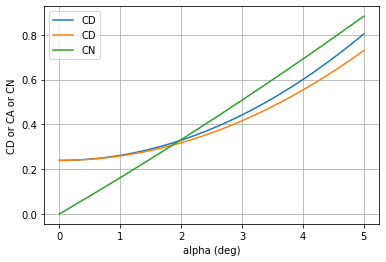

In [147]:
alpha_vals = np.linspace(0,5)*ureg.degree
plt.plot(alpha_vals, [r.CD(alpha, Re=1e7) for alpha in alpha_vals],label='CD')
plt.plot(alpha_vals, [r.CA(alpha, Re=1e7) for alpha in alpha_vals],label='CD')
plt.plot(alpha_vals, [r.CN(alpha, Re=1e7) for alpha in alpha_vals],label='CN')
plt.xlabel('alpha (deg)')
plt.ylabel('CD or CA or CN')
plt.grid()


plt.legend()

In [148]:
r.CD(alpha=0*ureg.degree, Re=10e4, Mach=0.5)

0.7049134268793513 <Unit('dimensionless')>

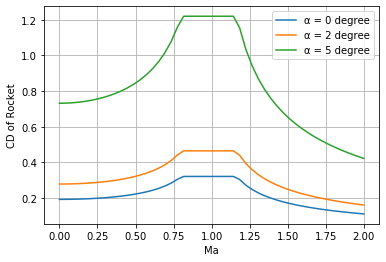

In [152]:
Ma_vals = np.linspace(0, 2)
Re=1e8
plt.plot(Ma_vals, [r.CD(alpha=0*ureg.degree, Re=Re, Mach=Ma) for Ma in Ma_vals], label='α = 0 degree')
plt.plot(Ma_vals, [r.CD(alpha=2*ureg.degree, Re=Re, Mach=Ma) for Ma in Ma_vals], label='α = 2 degree')
plt.plot(Ma_vals, [r.CD(alpha=5*ureg.degree, Re=Re, Mach=Ma) for Ma in Ma_vals], label='α = 5 degree')
plt.grid()
plt.xlabel("Ma")
plt.ylabel("CD of Rocket")
plt.legend()

(1.35636, 1.6916399999999998, -0.16554466256998948, 0.24373046733423745)

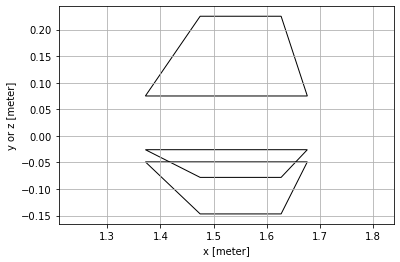

In [153]:

ax = fins.plot(rotation=10*ureg.degrees)
plt.axis('equal')